In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import pickle 
from ply import write_ply

from scipy.special import sph_harm

from utilities import *
from VoxelGrid import VoxelGrid
import os

from pyvox.models import Vox, Color
from pyvox.writer import VoxWriter
from PIL import ImageFont
from PIL import ImageDraw 

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device='cuda' if torch.cuda.is_available() else 'cpu'

N_points=200

In [2]:
focal, all_c2w, all_gt = get_data("../lego")

LOAD DATA ../lego/train


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 46.40it/s]


In [3]:
red = 8
target_ims, rays = reduce_data(all_c2w, all_gt, focal, red)
im_w = target_ims[0].shape[0]
print(im_w)

red = 2
disp_ims, disp_rays = reduce_data(all_c2w, all_gt, focal, red)
disp_im_w = disp_ims[0].shape[0]
print(disp_im_w)

100
400


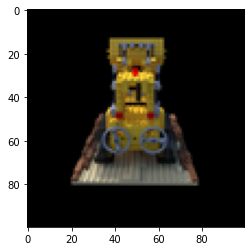

In [4]:
plt.imshow(target_ims[0])
plt.show()

In [5]:
test_focal, test_c2w, test_gt = get_data("../lego", "test")

LOAD DATA ../lego/test


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 52.74it/s]


In [6]:
red = 4
disp_ims_test, disp_rays_test = reduce_data(test_c2w, test_gt,test_focal, red)
disp_im_w = disp_ims[0].shape[0]

In [7]:
D = RayDataset(target_ims, rays, device)
train_loader = torch.utils.data.DataLoader(D, batch_size=5000, shuffle=True)

100%|█████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]


In [28]:
class VoxelGridSpherical(VoxelGrid):
    def clamp(self):
        with torch.no_grad():
            self.opacities[:] = torch.clamp(self.opacities, 0)
            self.colors[:] = torch.clamp(self.colors, 0,1)
    def copy(self):
        CopyGrid = VoxelGridSpherical(self.size,self.bound_w, self.num_harm)
        CopyGrid.colors = torch.clone(self.colors)
        CopyGrid.opacities = torch.clone(self.opacities)
        return CopyGrid
    
    def subdivide(self):
        with torch.no_grad():

            old_ind = regular_3d_indexes(self.size)

            self.size = 2 * self.size

            new_colors =  Variable(torch.rand((self.size*self.size*self.size,3, self.num_harm)).to(device), requires_grad=True)
            new_opacities =  Variable(torch.rand((self.size*self.size*self.size)).to(device), requires_grad=True)

            offsets = [np.array([0,0,0]), np.array([1,0,0]),np.array([0,1,0]), np.array([0,0,1]),
                      np.array([0,1,1]), np.array([1,1,0]), np.array([1,0,1]), np.array([1,1,1])]
            
            for off in offsets:
                target_inds = self.flatten_3d_indices(2*old_ind+off)
                new_colors[target_inds,:,:] = self.colors[:]
                new_opacities[target_inds] = self.opacities[:]
            self.colors = new_colors
            self.opacities = new_opacities
            
    def __init__(self, size=128, bound_w=1, num_harm=4):
        self.size = size
        self.bound_w = bound_w
        self.num_harm = 4
        self.colors =  Variable(torch.rand((size*size*size,3,num_harm)).to(device), requires_grad=True)
        self.opacities =  Variable(torch.rand((size*size*size)).to(device), requires_grad=True)


    def view_harmonics(self, point):
        r1 =  torch.sqrt((point**2).sum())
        r2 = torch.sqrt((point[:2]**2).sum())
        theta = torch.arcsin(r2/r1).cpu().numpy()
        phi = torch.arccos(point[0].abs()/r2).cpu().numpy()
        phi *= 1 if point[1]>0 else -1
        harmonics = np.array([sph_harm(j,i,theta, phi) 
                              for i in range(int(np.sqrt(self.num_harm))) 
                              for j in range(-i,i+1)])
        return torch.tensor(np.abs(harmonics), dtype=torch.float32, device=device)

    def render_rays(self, ordir_tuple, N_points, inv_depth=1.2):

        ori = ordir_tuple[0][:, None,:]

        # WARNING: Assuming constant distance
        distances = 10*torch.sqrt( (ordir_tuple[1]**2).sum(1, keepdim=True))/inv_depth/(N_points-1)
        scatter_points = torch.rand_like(distances)*distances + torch.linspace(0,10, N_points, device=device)[None, :]/inv_depth
        p = ori + scatter_points[:,:,None]*(ordir_tuple[1][:, None, :])
        displacement = (2*self.bound_w)/self.size
        with torch.no_grad():
            # extract valid indices
            inds_3d = torch.floor(self.descartes_to_indices(p))
            in_bounds = self.in_bounds_indices(inds_3d)
            # meshgrid coordinates
            mesh_coords = self.flatten_3d_indices(inds_3d.long())
            mesh_coords[torch.logical_not(in_bounds)] = 0
            harmonics = self.view_harmonics(p[0,0])

            
        colors = torch.tensordot(self.colors[mesh_coords],harmonics, dims=([-1], [0]))
        
        opacities = self.opacities[mesh_coords]*in_bounds.float() # not_in bounds: 0 opacity

        opacities = opacities*distances
        cumsum_opacities = torch.cumsum(opacities, 1)

        transp_term = torch.exp(-cumsum_opacities)*(1-torch.exp(-opacities))
        return (colors*transp_term[..., None]).sum(1)

In [29]:
VG = VoxelGridSpherical(32, 1.2, 4)

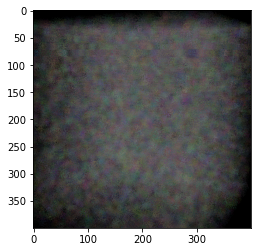

In [10]:
#VG.load('32_2sph.obj')
#VG.subdivide()
plt.imshow(VG.render_image_from_rays(disp_rays[10],(50, 1.2)))

In [32]:
losses=[]
VG.size

128

  0%|                                                     | 0/2 [00:00<?, ?it/s]

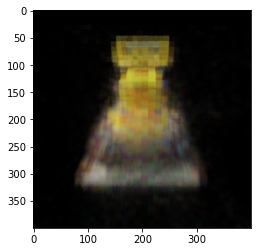

Train Epoch: 0 [0/200 (0%)]	Loss: 0.038656
Train Epoch: 0 [10/200 (5%)]	Loss: 0.037849
Train Epoch: 0 [20/200 (10%)]	Loss: 0.037867
Train Epoch: 0 [30/200 (15%)]	Loss: 0.036180
Train Epoch: 0 [40/200 (20%)]	Loss: 0.038113
Train Epoch: 0 [50/200 (25%)]	Loss: 0.046166
Train Epoch: 0 [60/200 (30%)]	Loss: 0.035474
Train Epoch: 0 [70/200 (35%)]	Loss: 0.037662
Train Epoch: 0 [80/200 (40%)]	Loss: 0.037113
Train Epoch: 0 [90/200 (45%)]	Loss: 0.039974
Train Epoch: 0 [100/200 (50%)]	Loss: 0.035431
Train Epoch: 0 [110/200 (55%)]	Loss: 0.039680
Train Epoch: 0 [120/200 (60%)]	Loss: 0.038442
Train Epoch: 0 [130/200 (65%)]	Loss: 0.039031
Train Epoch: 0 [140/200 (70%)]	Loss: 0.036144
Train Epoch: 0 [150/200 (75%)]	Loss: 0.035817
Train Epoch: 0 [160/200 (80%)]	Loss: 0.038064
Train Epoch: 0 [170/200 (85%)]	Loss: 0.039612
Train Epoch: 0 [180/200 (90%)]	Loss: 0.041018
Train Epoch: 0 [190/200 (95%)]	Loss: 0.037927


 50%|██████████████████████                      | 1/2 [02:29<02:29, 149.07s/it]


RuntimeError: CUDA out of memory. Tried to allocate 1.43 GiB (GPU 0; 7.77 GiB total capacity; 2.74 GiB already allocated; 1.25 GiB free; 5.17 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [33]:
N_points=200

optimizer = torch.optim.SGD(
            [VG.colors, VG.opacities], 
            lr=1000
        )

def train(epoch):
    losses=[]
    for batch_idx, (rays, pixels) in enumerate(train_loader):
        optimizer.zero_grad()
        
        pix_estims = VG.render_rays(rays, (N_points))
        
        #loss = ((pix_estims-pixels)**2).sum()/rays[0].shape[0] +0.0001*VG.total_variation()
        loss = ((pix_estims-pixels)**2).sum()/rays[0].shape[0]
        loss.backward()
        losses.append(loss.item())
        #VG.update_grads(1000)
        optimizer.step()
        VG.clamp()
        if batch_idx%10==0:
            print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        epoch,
                        batch_idx,
                        len(train_loader),
                        100.0 * batch_idx / len(train_loader),
                        loss.data.item(),
                    )
                )
    return losses

for epoch in tqdm(range(2)):
    new_im = VG.render_image_from_rays(disp_rays[0],(200,1.2))
    #VG.treshold_opacity(0.2)
    plt.imshow(new_im)
    plt.show()
    #plt.imsave('screenshots/a'+str(epoch)+'.png', new_im)



    losses += train(epoch)
    #VG.save('80_'+str(epoch)+'.obj')
    
    

In [30]:
VG.load('32_2sphSGD+clamp.obj')

In [26]:
with torch.no_grad():
    c=0
    for i in range(10):
        rays, pixels = next(iter(train_loader))
        pix_estims = VG.render_rays(rays, (N_points))

        #loss = ((pix_estims-pixels)**2).sum()/rays[0].shape[0] +0.0001*VG.total_variation()
        loss = ((pix_estims-pixels)**2).sum()/rays[0].shape[0]
        c+=loss
    print(c)

tensor(0.4004, device='cuda:0')


In [44]:
m = torch.rand((3,4,8))
n = torch.rand(8)

Text(0.5, 0, 'Iterations')

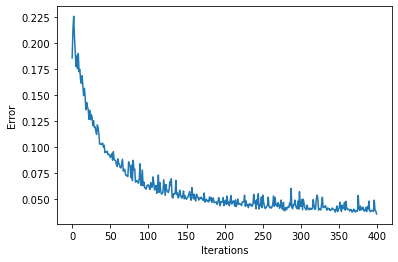

In [25]:
plt.plot((np.array(losses)))




plt.ylabel("Error")
plt.xlabel("Iterations")
#plt.savefig('exports/2epochs_32.png')

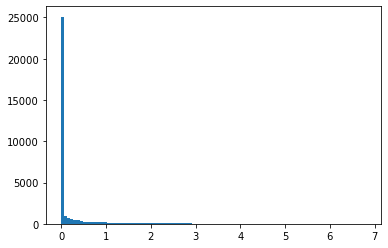

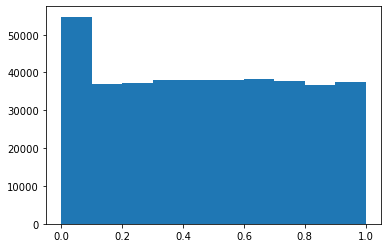

In [24]:
plt.hist(VG.opacities.tolist(), bins=100)
plt.show()
plt.hist(VG.colors.flatten().tolist())
plt.show()




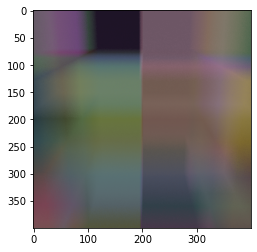

In [24]:
plt.imshow(VG.render_image_from_rays(disp_rays[0],(100, 1.2)))

In [70]:
plt.imshow(VG.render_image_from_rays(disp_rays[0],(100, 1.2)))

RuntimeError: CUDA out of memory. Tried to allocate 368.00 MiB (GPU 0; 7.77 GiB total capacity; 6.08 GiB already allocated; 25.00 MiB free; 6.39 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [28]:
VG2.save_magica_vox(0.4)
#VG.save('.obj')

100%|███████████████████████████████████████████| 64/64 [00:25<00:00,  2.51it/s]


In [26]:
c = VG2.make_palette(16)

ValueError: Image RGB array must be uint8 or floating point; found int64

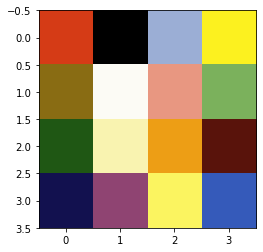

In [27]:
plt.imshow(c[1][:,:3].reshape((4,4,3)))

#plt.imsave('exporsts/64_best_palette.png', c[1][:,:3].reshape((4,4,3)))

In [22]:
all_c2w[image_ind]

disp_rays[image_ind][0][0,:,0]**2

array([8.33201508, 6.31625955, 1.60172607])

# TEST

In [10]:
VG2 = VoxelGrid()
VG2.load('64_best.obj')
VG2.bound_w

1.2

In [22]:
len(disp_ims_test)

200

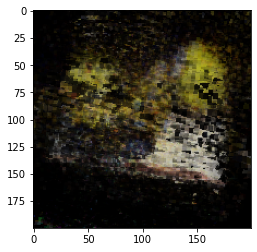

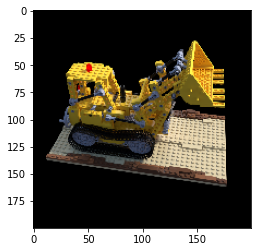

In [37]:
image_ind=28
tensor_rays_img = torch.tensor(disp_rays_test[image_ind], dtype=torch.float32).to(device).permute((0,1,3,2)).view((disp_im_w*disp_im_w,N_points,3))

new_im = VG2.render_rays(tensor_rays_img).view((disp_im_w,disp_im_w,3)).cpu().detach().numpy()

plt.imshow(new_im)
plt.show()
plt.imshow(disp_ims_test[image_ind])

# ROTATION

In [11]:
rays_or_dir = [get_rays_np(800,800, focal, c2w) for c2w in all_c2w]

In [12]:
camera_centers = get_cameras_centers(rays_or_dir)

[3.8 0.  1. ]


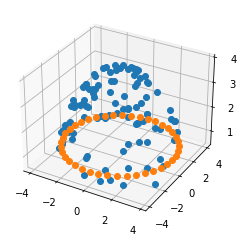

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot( camera_centers[:,0], camera_centers[:, 1], camera_centers[:,2], 'o')

n = 40
t = np.linspace(0,2*np.pi, n+1)[:-1]
cust_centers = np.zeros((n,3))
cust_centers[:,0] = np.cos(t)*3.8
cust_centers[:,1] = np.sin(t)*3.8
cust_centers[:,2] = 1

cust_c2ws = [create_rotation_transformation_matrix(cust_centers[i], t[i], -np.pi*0.1) for i in range(n)]

ax.plot( cust_centers[:,0], cust_centers[:,1], cust_centers[:,2], 'o')

print(cust_centers[0])



In [14]:
cust_c2ws = create_rotation_matrices(1,-10, n=40)

In [15]:
red_fac=4
ordir_rays=[]
for c2w in cust_c2ws:
    ray_np = get_rays_np(800,800, focal, c2w)
    oris = ray_np[0][::red_fac,::red_fac]
    direct = ray_np[1][::red_fac,::red_fac] # direction. optimal fac:3
    ordir_rays.append((oris, direct))



In [56]:

VG = VoxelGridSpherical(100, 1)
with torch.no_grad():
    VG.opacities[:]=10

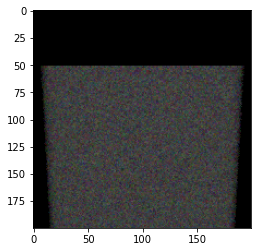

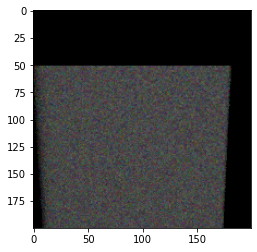

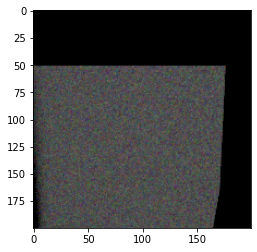

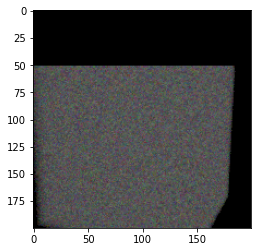

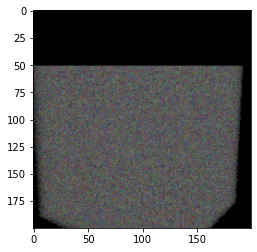

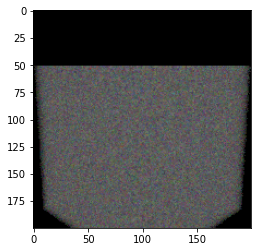

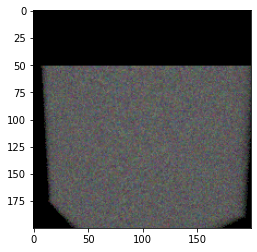

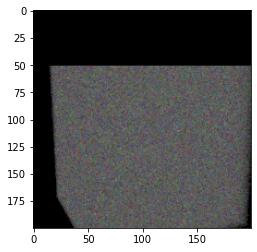

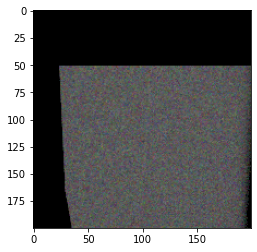

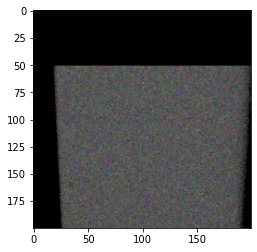

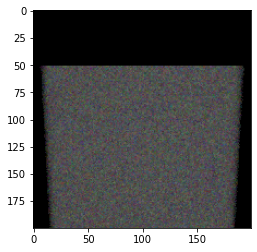

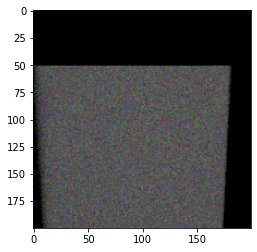

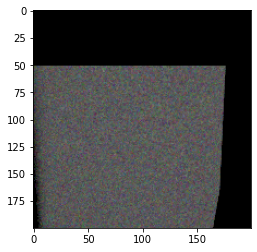

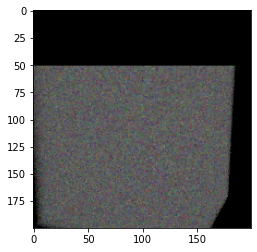

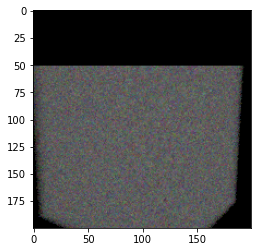

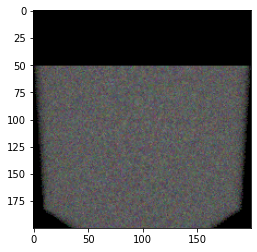

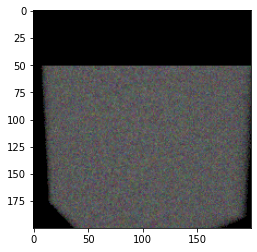

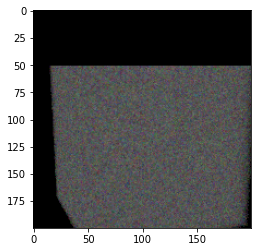

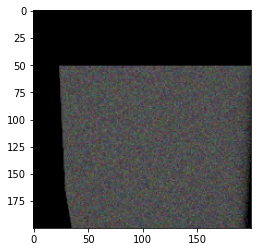

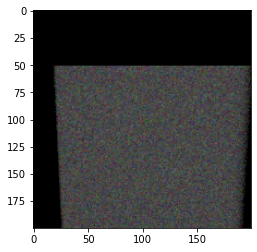

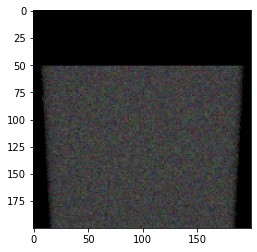

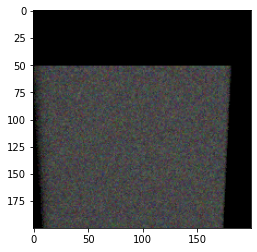

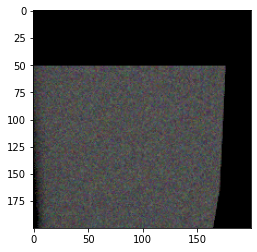

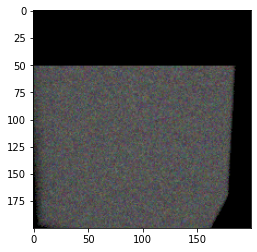

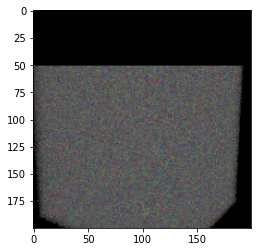

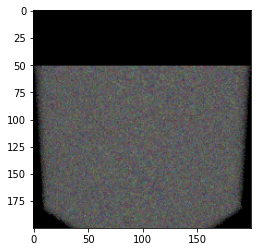

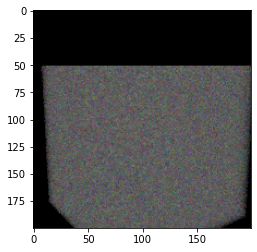

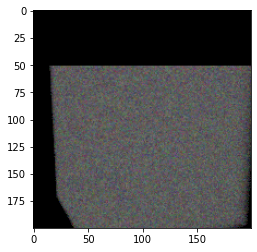

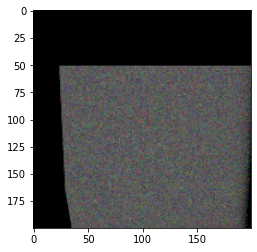

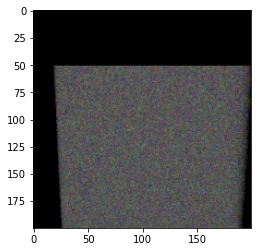

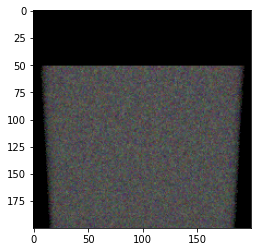

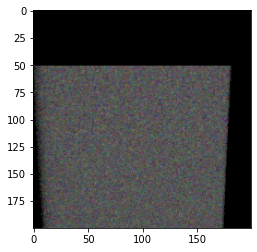

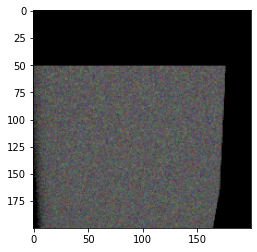

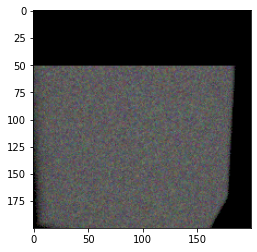

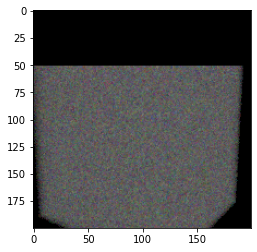

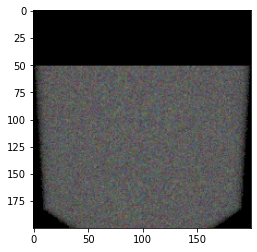

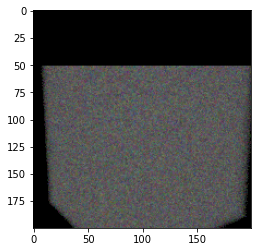

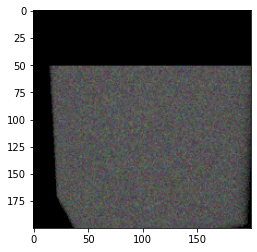

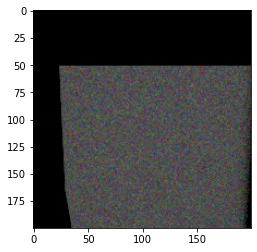

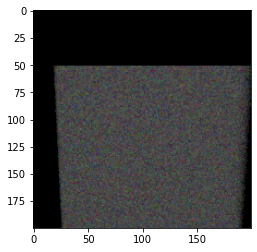

In [57]:
for image_ind in (range(len(cust_c2ws))):
        #new_im = VG.render_large_image_from_rays(ordir_rays[image_ind],(1000, 1.2), 500)
        new_im = VG.render_image_from_rays(ordir_rays[image_ind],(200, 1.2))
        plt.imshow(new_im)
        plt.show()

In [12]:
L=[]
k=0
i=0
while i<39:
    k+=1
    for _ in range(4):
        L.append(i)
        i+=k
L

[0, 1, 2, 3, 4, 6, 8, 10, 12, 15, 18, 21, 24, 28, 32, 36]

In [13]:

images=[]
for ind in tqdm(L):
    VG.load('64a_'+str(ind)+'.obj')
    for image_ind in (range(len(cust_c2ws))):
        new_im = VG.render_image_from_rays(ordir_rays[image_ind], (1000, 2))
        img = Image.fromarray(np.uint8(255*new_im))
        draw = ImageDraw.Draw(img)
        draw.text((10, 10),"Epoch:"+str(ind),(255,255,255))
        images.append(np.array(img))
        #plt.imshow(images[-1])
        #plt.show()
        #images.append(np.uint8(255*new_im))
        plt.imsave('screenshots/rotate/'+str(ind)+'_'+str(image_ind)+'.png', new_im)


100%|███████████████████████████████████████████| 16/16 [00:50<00:00,  3.17s/it]


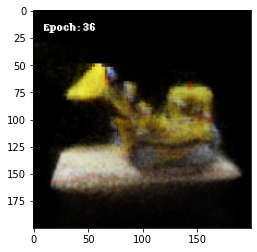

In [20]:
plt.imshow(images[-1])

In [19]:
imageio.mimwrite('screenshots/movies.gif', images,  format='GIF', duration=0.1)

# Spherical

In [9]:
L = [np.abs(sph_harm(0,1,np.random.random(),np.random.random())) for i in range(1000)]



(array([ 62.,  43.,  65.,  76.,  61.,  71.,  81., 101., 119., 321.]),
 array([0.26444754, 0.28686303, 0.30927851, 0.33169399, 0.35410948,
        0.37652496, 0.39894044, 0.42135593, 0.44377141, 0.4661869 ,
        0.48860238]),
 <BarContainer object of 10 artists>)

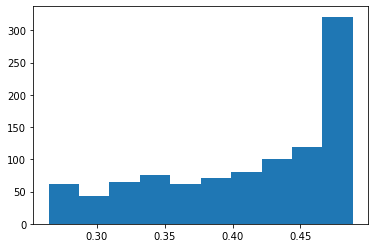

In [10]:
plt.hist(L)